In [199]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from scipy.optimize import minimize

<h4>Parameters<h4>

In [200]:
segment_count_beam = 100
vertical_level_count = 40
length_beam = 1000 # mm
horizontal_force = 7.4121 # N, + compression, - tension
youngs_modulus = 2e3 # MPa
moment_of_inertia = 20 # mm^4
channel_width_half = 10 # mm
boundary_penalty_coefficient = 0
pinned_penalty_coefficient = 0

In [201]:
3.14**2 * youngs_modulus * moment_of_inertia / length_beam**2

0.394384

<h4>Initial Guess<h4>

In [202]:
# ensure y=0 is possible
if vertical_level_count % 2 == 0:
    previous_vertical_level_count = vertical_level_count
    vertical_level_count +=1

# ensure ds>dy_max
if segment_count_beam > length_beam/(2*channel_width_half):
    previous_segment_count_beam = segment_count_beam
    segment_count_beam = int(length_beam/(2*channel_width_half))

y_levels = np.linspace(-channel_width_half, channel_width_half, vertical_level_count)
s, ds = np.linspace(0, length_beam, segment_count_beam+1, retstep=True)

In [203]:
def g(I_val, J_val, K_val):
    theta1 = np.arcsin((J_val - I_val) / ds)
    theta2 = np.arcsin((K_val - J_val) / ds)

    internal_strain_energy = 0.5 * youngs_modulus * moment_of_inertia * ( (theta2 - theta1)/ds )**2 * ds
    external_force_work = horizontal_force * np.cos(theta1) * ds
    
    return internal_strain_energy + external_force_work

In [204]:
C = {}
survivor = {}
index_zero = vertical_level_count//2

for I, J in product(range(vertical_level_count), repeat=2):
    if I == index_zero:
        C[(I, J, 1)] = 0
        survivor[(I, J, 1)] = None
    else:
        C[(I, J, 1)] = np.inf
        survivor[(I, J, 1)] = None

for m in range(2, segment_count_beam + 1):
    for J, K in product(range(vertical_level_count), repeat=2):
        best_cost = np.inf
        best_prev_I = None

        for I in range(vertical_level_count):
            prev_state_key = (I, J, m - 1)
            prev_cost = C.get(prev_state_key, np.inf)

            if prev_cost == np.inf:
                continue

            trans_cost = g(y_levels[I], y_levels[J], y_levels[K])
            total_cost = prev_cost + trans_cost

            if total_cost < best_cost:
                best_cost = total_cost
                best_prev_I = I

        C[(J, K, m)] = best_cost
        survivor[(J, K, m)] = best_prev_I

min_cost = np.inf
best_final_key = None

for J, K in product(range(vertical_level_count), repeat=2):
    current_key = (J, K, segment_count_beam)
    cost = C.get(current_key, np.inf)
    if cost < min_cost and K == index_zero:
        min_cost = cost
        best_final_key = current_key

if best_final_key is None or min_cost == np.inf:
    print("No valid path found (possibly all paths lead to infinite cost).")
else:
    path_indices = []
    current_J, current_K, current_m = best_final_key

    path_indices.append(current_K)
    path_indices.append(current_J)

    for m_step in range(segment_count_beam, 1, -1):
        prev_I = survivor[(current_J, current_K, m_step)]
        if prev_I is None:
            break
        path_indices.append(prev_I)
        current_K = current_J 
        current_J = prev_I


    final_J, final_K, _ = best_final_key
    reconstructed_y_indices = [final_K]
    reconstructed_y_indices.append(final_J)

    current_J_trace = final_J
    current_K_trace = final_K

    for m_trace in range(segment_count_beam, 1, -1):
        prev_I_trace = survivor[(current_J_trace, current_K_trace, m_trace)]
        if prev_I_trace is None:
            break
        reconstructed_y_indices.append(prev_I_trace)
        current_K_trace = current_J_trace
        current_J_trace = prev_I_trace

    reconstructed_y_indices.reverse()
    y_viterbi = [y_levels[i] for i in reconstructed_y_indices]

In [205]:
def x_from_y(y):
    dy = np.diff(y)
    dx = np.sqrt(ds**2 - dy**2)
    x = np.cumulative_sum(dx, include_initial=True)
    return x

In [206]:
x_viterbi = x_from_y(y_viterbi)
print(f"Δx = {x_viterbi[-1]-length_beam:.1f} mm")

# plt.figure()
# plt.plot(s, y_viterbi, marker="", linestyle="--", label = "y(s)")
# plt.plot(x_viterbi, y_viterbi, marker="", linestyle="--", label="y(x)")
# plt.axhline(channel_width_half)
# plt.axhline(-channel_width_half)
# plt.grid()
# plt.legend()
# plt.ylabel("y [mm]")
# plt.axis("equal")
# plt.show()

Δx = -2.3 mm


In [207]:
def energy_functional(y):
    v = 0
    for i in range(len(y)-2):
        theta1 = np.arcsin((y[i+1] - y[i]) / ds)
        theta2 = np.arcsin((y[i+2] - y[i+1]) / ds)
        kappa = (theta2 - theta1) / ds
        internal_strain_energy = 0.5 * youngs_modulus * moment_of_inertia * kappa**2 * ds
        v += internal_strain_energy

    for i in range(len(y)-1):
        theta1 = np.arcsin((y[i+1] - y[i]) / ds)
        external_force_work = horizontal_force * np.cos(theta1) * ds
        v+=external_force_work
    
    return v

In [208]:
res = minimize( 
    energy_functional, 
    x0=y_viterbi, 
    constraints = [
        {"type": "eq", "fun": lambda y: y[-1]},
        {"type": "eq", "fun": lambda y: y[ 0]}
        ],
    bounds = [
        (-channel_width_half, channel_width_half) for _ in range(segment_count_beam+1)
        ],
    method="SLSQP"
)

y_minimized = res.x
x_minimized = x_from_y(y_minimized)

In [209]:
def energy_functional2(y):
    theta = np.arcsin(np.diff(y)/ds)
    diffs = np.diff(theta)
    v = 0.5 * youngs_modulus * moment_of_inertia * np.sum( (diffs/ds)**2 ) * ds + horizontal_force * np.sum(np.cos(theta)) * ds

    return v

In [210]:
res2 = minimize(
    energy_functional2,
    x0 = y_viterbi,
    method="SLSQP",
    constraints = [{"type": "eq", "fun": lambda y: y[-1]},
                {"type": "eq", "fun": lambda y: y[0]}],
    bounds = [(-channel_width_half, channel_width_half)
                for _ in range(segment_count_beam+1)],
)

y_minimized2 = res2.x
x_minimized2 = x_from_y(y_minimized2)

In [211]:
header = f'{"PARAMETER":<25}  {"VALUE":<10}  {"UNIT":<10}'

parameters_data = [
    ("Beam Segment Count", segment_count_beam, ""),
    ("Vertical Level Count", vertical_level_count, ""),
    ("Beam Length", length_beam, "mm"),
    ("Horizontal Force", horizontal_force, "N"),
    ("Young's Modulus", youngs_modulus, "MPa"),
    ("Moment of Inertia", moment_of_inertia, "mm^4"),
    ("Channel Half-Width", channel_width_half, "mm"),
    ("Boundary Penalty Coeff", f"{boundary_penalty_coefficient:.0e}", ""),
    ("Pinned Penalty Coeff", f"{pinned_penalty_coefficient:.0e}", ""),
    ("Beam End x-Displacement", f"{x_minimized[-1]-length_beam:.1f}", "mm"),

]

body_lines = []
for name, value, unit in parameters_data:
    value_str = str(value)
    body_lines.append(f"{name:<25}  {value_str:<10}  {unit:<10}")

solver_params_string = "\n".join([
    header,
    *body_lines
])

The beam segment count has been adjusted to 50 (was 100).
The vertical level count has been adjusted to 41 (was 40).

 SLSQP  message: Optimization terminated successfully
 success: True
  status: 0
     fun: 7403.299216179812
       x: [ 0.000e+00 -1.977e+00 ... -1.977e+00  0.000e+00]
     nit: 76
     jac: [-2.994e-01  6.104e-05 ...  0.000e+00 -2.994e-01]
    nfev: 4010
    njev: 76

 Vectorised SLSQP  message: Optimization terminated successfully
 success: True
  status: 0
     fun: 7403.299216141765
       x: [ 0.000e+00 -1.976e+00 ... -1.977e+00  0.000e+00]
     nit: 75
     jac: [-2.996e-01  6.714e-04 ...  6.104e-05 -2.992e-01]
    nfev: 3965
    njev: 75


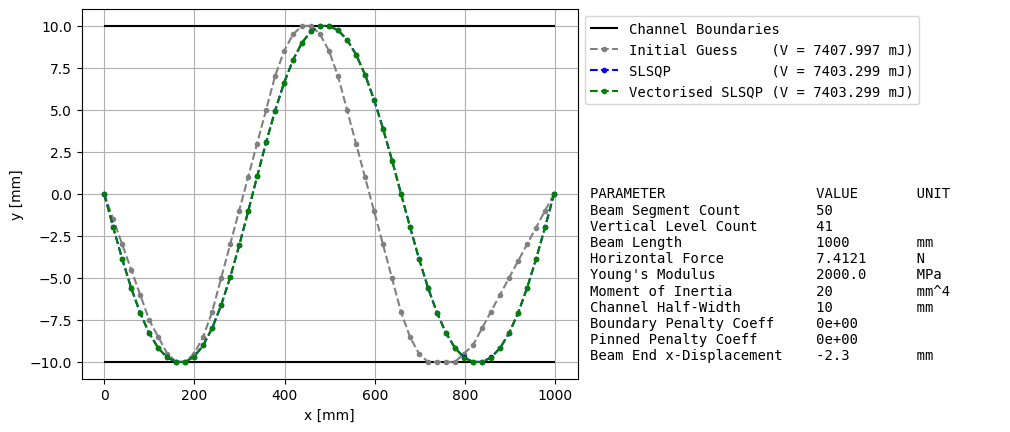

In [212]:
if previous_segment_count_beam != segment_count_beam:
    print(f"The beam segment count has been adjusted to {segment_count_beam} (was {previous_segment_count_beam}).")

if previous_vertical_level_count != vertical_level_count:
    print(f"The vertical level count has been adjusted to {vertical_level_count} (was {previous_vertical_level_count}).")

print("\n", "SLSQP", res)
print("\n", "Vectorised SLSQP", res2)

plt.hlines(channel_width_half, 0, length_beam, color="black", label="Channel Boundaries")
plt.hlines(-channel_width_half, 0, length_beam, color="black")
plt.plot(x_viterbi, y_viterbi, marker=".", linestyle="--", color="grey",
          label=f"Initial Guess    (V = {energy_functional2(np.array(y_viterbi)):.3f} mJ)")
plt.plot(x_minimized, y_minimized, marker=".", linestyle="--", color="blue",
          label=f"SLSQP            (V = {energy_functional2(y_minimized):.3f} mJ)")
plt.plot(x_minimized2, y_minimized2, marker=".", linestyle="--", color="green",
          label=f"Vectorised SLSQP (V = {res2.fun:.3f} mJ)")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1), prop="monospace")
plt.figtext(0.92, 0.15, solver_params_string, fontfamily="monospace")
plt.xlabel("x [mm]")
plt.ylabel("y [mm]")
# plt.axis("equal")
plt.grid()
plt.show()